In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import r2_score
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

## 1. Introduction

When analyzing NBA player performance and team strategy, accurately predicting the binary outcome of each shot (`made = 1`, `missed = 0`) is important. Coaches, players, and data analysts use large shot-chart datasets to optimize shot selection. As the Sports Journal (2013) observed:

> “The finding that field goal percentage rate explained a very large proportion of the variance in success (i.e., 61.4%) highlights the importance of offensive efficiency not only of the starting players but also of the ‘bench’ players, since the latter group also contribute to the field goal percentage rate.”

In practice facilities across the league, the Noah Shooting System is installed above the hoop to capture the ball’s flight path 30 times per second. It measures key shooting metrics, such as shot arc, depth, and left/right position, and provides instant verbal feedback to help players develop consistent mechanics. Mike Dunleavy Jr., Vice President of Basketball Operations for the Golden State Warriors, emphasizes its impact:

> “The data generated is used heavily by the Golden State Warriors and is a big part of our player development program. We have seen first-hand how it can improve shooting percentages.”


### Citations

- Factors associated with success among NBA teams. The Sport Journal. (2013, November 27). https://thesportjournal.org/article/factors-associated-with-success-among-nba-teams/ 
- Now used by 26 of 30 NBA teams. Noah Basketball - Choose Your Service. (2022). https://www.noahbasketball.com/blog/26-of-30-nba-teams 


In this project, we build a **logistic-regression model** to predict `SHOT_MADE`, our **response variable**, based on five key predictors:

- **Categorical**  
  - `SHOT_TYPE` (e.g. jump, layup, dunk)  
  - `PLAYER_POSITION` (guard, wing, big)  
  - `COURT_REGION` (paint, mid-range, three-point)  
- **Numerical**  
  - `SHOT_DISTANCE` (feet)  
  - `QUARTER`(1-6)

We train and validate our model on a dataset of **20,000+ NBA shots** from the 2023–24 regular season, using **five-fold cross-validation** to optimize using selected paramaters and evaluate performance via **area under the ROC curve (AUC)**.

---

### Research Goals

1. **Primary Goal**
    - Build a predictive model that will effectively predict `SHOT_MADE` for new datasets. Our method of appraoch will be to maximize predictive accuracy (AUC) for new shot-chart data through five-fold cross-validation.

2. **Secondary Goals**   
   - **Interaction analysis:** Explore joint effects (e.g. how distance & shot type influence shot probability).  
   - **Actionable insights:** Provide recommendations for NBA analysts to design plays with higher expected scoring efficiency based on our models performace. 


## 2. Dataset Discussion

We analyze the 2024 NBA regular-season shot location dataset compiled by Dom Samangy, Basketball Analytics Coordinator for the New Orleans Pelicans, and downloaded on April 22, 2025 from the GitHub repository (https://github.com/DomSamangy/NBA_Shots_04_25). Each of the 218,701 rows in this CSV represents a single shot attempt recorded during the 2024 NBA season. The data was crowd-sourced from NBA.com API feeds via scraping and manual aggregation, so they may exclude certain unlogged or unofficial plays (e.g., Preseason or Summer League games), which could cause bias in our model if those shot types differ systematically. Coaches using our predictions should be aware that under-recorded situations may lead the model to over or under-estimate success rates in `SHOT_MADE` in this context.

### Selected Variables

**Response**  
- **`SHOT_MADE`** (1 = made, 0 = missed): Predicting shot success directly shows offensive efficiency for players and teams.

**Explanatory**  
- **`POSITION`** (Guard, Wing, Big): Guards, wings, and bigs face different defensives, shot roles vary.  
- **`SHOT_TYPE`** (2PT vs. 3PT): Type of shot chosen (2PT or 3PT).  
- **`ZONE_ABB`** Court side abbreviations: L = Left Wing, LC = Left-Center, C = Center, RC = Right-Center, R = Right Wing.
- **`SHOT_DISTANCE`** (feet): Distance of the shot with respect to the center of the hoop.  
- **`QUARTER`** (1–4): Quarter of the game. Standard games have 4 quarters, but overtime can extend the total to 5 or 6.

Our five explanatory variables include three categorical variables: **`POSITION`** , **`SHOT_TYPE`**, and **`ZONE_ABB`**, and two numerical variables: **`SHOT_DISTANCE`** and **`QUARTER`**. These variables were selected because they are most likely to influence the probability of making a shot. We expect that factors like the distance from the basket and the type of shot will have significant impacts on the response varaible, **`SHOT_MADE`**.

---

### Observations Left Out and Why We Didn’t Use Them

We decided to remove some variables from our dataset because they were either too repetitive, too specific, or not useful for our current goals. Here's how we grouped them:

**Redundant (We use better varaibles)**

- `ZONE_NAME`, `BASIC_ZONE`, `ZONE_RANGE`  
  These were removed because `ZONE_ABB` already gives us a more detailed zone description.

- `POSITION_GROUP`  
  This just splits players into Guards (G), Forwards (F), and Centers (C), but `POSITION` gives us more detailed roles like PG, SG, etc.

- `ACTION_TYPE`  
  Even though this could be helpful, we already have `SHOT_TYPE`, which shows the point value (2PT or 3PT) and is easier to work with.

**Too Much Variability**

- `SEASON_1`, `SEASON_2`, `TEAM_ID`, `TEAM_NAME`, `PLAYER_ID`, `PLAYER_NAME`  
  These all have lots of unique or specific values, making them hard to use in a general model.

- `GAME_ID`, `EVENT_TYPE`  
  These are hard to measure unless we focused on one specific team or event at a time.

**Already Removed or Not Needed**

- `GAME_DATE`  
  All date data was already taken out from the original dataset.

**Could Be Useful, But We Didn’t Include Them**

- `LOC_X`, `LOC_Y`  
  These give shot locations on the court, but we weren’t sure how to handle the exact coordinates.

- `MINS_LEFT`, `SECS_LEFT`  
  Time left in the game could matter, but we didn’t include them in this version. We might use them in the future.



In [2]:
df = pd.read_csv("NBA_2024_Shots.csv")
df.head()

,SEASON_1,SEASON_2,TEAM_ID,TEAM_NAME,PLAYER_ID,PLAYER_NAME,POSITION_GROUP,POSITION,GAME_DATE,GAME_ID,...,BASIC_ZONE,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT
0,2024,2023-24,1610612764,Washington Wizards,1629673,Jordan Poole,G,SG,11/3/2023,22300003,...,In The Paint (Non-RA),Center,C,8-16 ft.,-0.4,17.45,12,1,11,1
1,2024,2023-24,1610612764,Washington Wizards,1630166,Deni Avdija,F,SF,11/3/2023,22300003,...,Above the Break 3,Center,C,24+ ft.,1.5,30.55,25,1,10,26
2,2024,2023-24,1610612764,Washington Wizards,1626145,Tyus Jones,G,PG,11/3/2023,22300003,...,Restricted Area,Center,C,Less Than 8 ft.,-3.3,6.55,3,1,9,46
3,2024,2023-24,1610612764,Washington Wizards,1629673,Jordan Poole,G,SG,11/3/2023,22300003,...,Restricted Area,Center,C,Less Than 8 ft.,-1.0,5.85,1,1,8,30
4,2024,2023-24,1610612764,Washington Wizards,1626145,Tyus Jones,G,PG,11/3/2023,22300003,...,Restricted Area,Center,C,Less Than 8 ft.,0.0,6.25,1,1,8,8


In [3]:
print("There are", df.shape[0] ,"rows.")

There are 218701 rows.


**Making Reponse Varaible** 

In [4]:
df['y'] = df['SHOT_MADE'].replace({True:1, False:0})
df["y"]

C:\Users\cjsla\AppData\Local\Temp\ipykernel_35328\631131598.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['SHOT_MADE'].replace({True:1, False:0})


0         0
1         1
2         1
3         1
4         1
         ..
218696    0
218697    0
218698    1
218699    1
218700    0
Name: y, Length: 218701, dtype: int64

## 3. Data Cleaning

We started by checking the data types and unique values of the variables `SHOT_TYPE`, `ZONE_ABB`, `SHOT_DISTANCE`, `QUARTER`, `POSITION`, and `SHOT_MADE`. We also checked for missing values using **.isna().sum()**. We found 1,264 missing values in the `POSITION` column, so we dropped those rows, leaving 217,437 rows for analysis.

Next, we looked at the categories in `SHOT_TYPE`, `ZONE_ABB`, and `POSITION` to see if any were rare. The category **BC** in `ZONE_ABB` had only 464 observations, but BC (backcourt) is an important data point in our observations, so we decided to keep them all.

We then made a scatterplot of `SHOT_DISTANCE` vs `QUARTER` to check for outliers. Some shot distances were very high (up to 80 feet), but we decided not to remove them since they likely represent real long-distance shots like half-court shots.

**Outlier Cleaning**

We removed rows where the `QUARTER` value was greater than 4, as overtime games are rare and could create bias the data. This reduced the dataset by 1,176 rows, leaving 216,261 rows.

Finally, we removed rows with hybrid positions like **PF-SF** and **PG-SG** to keep the `POSITION` variable consistent. This reduced the dataset by 8,117 rows, leaving 210,584 rows.


In [5]:
vars = df[["SHOT_MADE", "POSITION", "SHOT_TYPE", "ZONE_ABB", "SHOT_DISTANCE", "QUARTER", 'y']]
vars.head()

,SHOT_MADE,POSITION,SHOT_TYPE,ZONE_ABB,SHOT_DISTANCE,QUARTER,y
0,False,SG,2PT Field Goal,C,12,1,0
1,True,SF,3PT Field Goal,C,25,1,1
2,True,PG,2PT Field Goal,C,3,1,1
3,True,SG,2PT Field Goal,C,1,1,1
4,True,PG,2PT Field Goal,C,1,1,1


In [6]:
vars.dtypes

SHOT_MADE          bool
POSITION         object
SHOT_TYPE        object
ZONE_ABB         object
SHOT_DISTANCE     int64
QUARTER           int64
y                 int64
dtype: object

In [7]:
vars.isna().sum()

SHOT_MADE           0
POSITION         1264
SHOT_TYPE           0
ZONE_ABB            0
SHOT_DISTANCE       0
QUARTER             0
y                   0
dtype: int64

In [8]:
vars['POSITION'].unique()

array(['SG', 'SF', 'PG', 'PF', 'PF-SF', 'C-PF', 'C', 'PF-C', 'PG-SG',
       'SF-PF', 'SG-PG', 'SF-SG', nan], dtype=object)

In [9]:
vars['SHOT_TYPE'].unique()

array(['2PT Field Goal', '3PT Field Goal'], dtype=object)

In [10]:
vars['ZONE_ABB'].unique()

array(['C', 'LC', 'RC', 'R', 'L', 'BC'], dtype=object)

In [11]:
df_clean = vars.dropna()
total_dropped = vars.shape[0] - df_clean.shape[0]

In [12]:
print("There are", total_dropped ,"total dropped rows after cleaning.")

There are 1264 total dropped rows after cleaning.


In [13]:
print("There are", df_clean.shape[0] ,"total rows.")

There are 217437 total rows.


In [14]:
df_clean.head()

,SHOT_MADE,POSITION,SHOT_TYPE,ZONE_ABB,SHOT_DISTANCE,QUARTER,y
0,False,SG,2PT Field Goal,C,12,1,0
1,True,SF,3PT Field Goal,C,25,1,1
2,True,PG,2PT Field Goal,C,3,1,1
3,True,SG,2PT Field Goal,C,1,1,1
4,True,PG,2PT Field Goal,C,1,1,1


In [15]:
df_clean['POSITION'].value_counts()

POSITION
SG       47279
PG       45355
SF       44096
PF       41055
C        33956
PG-SG     2633
SF-SG      850
SF-PF      779
C-PF       627
PF-C       469
PF-SF      190
SG-PG      148
Name: count, dtype: int64

In [16]:
df_clean['SHOT_TYPE'].value_counts()

SHOT_TYPE
2PT Field Goal    131738
3PT Field Goal     85699
Name: count, dtype: int64

In [17]:
df_clean['ZONE_ABB'].value_counts()

ZONE_ABB
C     123515
LC     27881
RC     26361
L      19816
R      19400
BC       464
Name: count, dtype: int64

In [18]:
df_clean['QUARTER'].value_counts()

QUARTER
1    56235
2    54349
3    54118
4    51559
5     1034
6      142
Name: count, dtype: int64

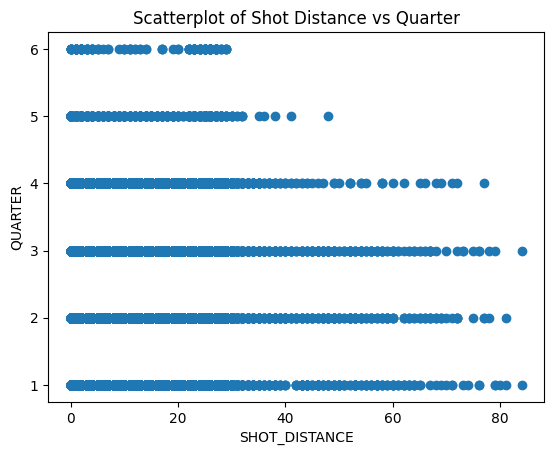

In [19]:
plt.scatter(df_clean['SHOT_DISTANCE'], df_clean['QUARTER'])
plt.xlabel('SHOT_DISTANCE')
plt.ylabel('QUARTER')
plt.title('Scatterplot of Shot Distance vs Quarter')
plt.show()

#### Removing Quarters Greater than 4

Since the pool of **overtime (OT)** games in this dataset is small and could affect the data, removing rows where the **quarter value** is greater than 4 seems justified. Overtime periods are rare, and their inclusion could introduce bias in our analysis.

In [20]:
df_clean = df_clean[df_clean["QUARTER"] <= 4]
df_clean

,SHOT_MADE,POSITION,SHOT_TYPE,ZONE_ABB,SHOT_DISTANCE,QUARTER,y
0,False,SG,2PT Field Goal,C,12,1,0
1,True,SF,3PT Field Goal,C,25,1,1
2,True,PG,2PT Field Goal,C,3,1,1
3,True,SG,2PT Field Goal,C,1,1,1
4,True,PG,2PT Field Goal,C,1,1,1
...,...,...,...,...,...,...,...
218696,False,SG,3PT Field Goal,LC,27,4,0
218697,False,C,2PT Field Goal,C,9,4,0
218698,True,C,2PT Field Goal,C,4,4,1
218699,True,SG,3PT Field Goal,C,29,4,1


In [21]:
df_clean["QUARTER"].unique()

array([1, 2, 3, 4])

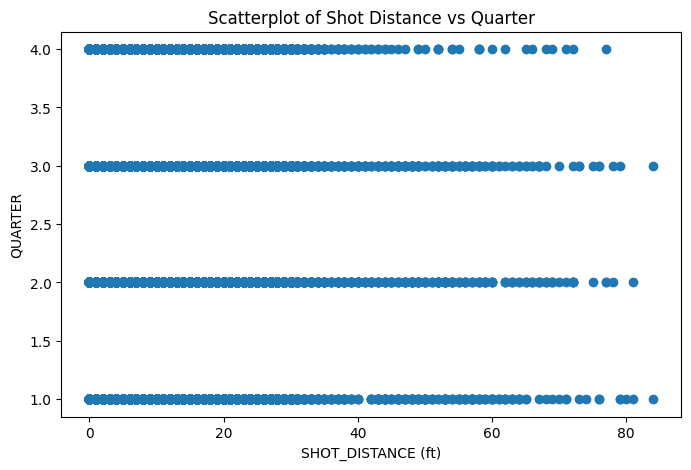

In [22]:
plt.figure(figsize=(8, 5))
plt.scatter(df_clean['SHOT_DISTANCE'], df_clean['QUARTER'])
plt.xlabel('SHOT_DISTANCE (ft)')
plt.ylabel('QUARTER')
plt.title('Scatterplot of Shot Distance vs Quarter')
plt.show()

In [23]:
remov_outlier = 217437-216261
remov_outlier

1176

In [24]:
print("There are", remov_outlier ,"total rows removed.")

There are 1176 total rows removed.


In [25]:
print("There are", df_clean.shape[0] ,"total rows after removing the outliers.")

There are 216261 total rows after removing the outliers.


### Removing Hybrid Position Players

Since the pool of hybrid position players in this dataset is small and could affect the data, removing rows where the position type listed shows multiple positions seems justified. Hybrid position players are rare, and their inclusion could introduce bias in our analysis. It's better to have a standard format than to introduce hybrid positions. 

In [26]:
df_clean["POSITION"].unique()

array(['SG', 'SF', 'PG', 'PF', 'PF-SF', 'C-PF', 'C', 'PF-C', 'PG-SG',
       'SF-PF', 'SG-PG', 'SF-SG'], dtype=object)

In [27]:
df_clean = df_clean[(df_clean["POSITION"] != "PF-SF")
                    &(df_clean["POSITION"] != "SF-PF")& (df_clean["POSITION"] != "C-PF")& (df_clean["POSITION"] != "PF-C")
                    & (df_clean["POSITION"] != "C-SF")& (df_clean["POSITION"] != "SF-C")&(df_clean["POSITION"] != 'PG-SG')
                    &(df_clean["POSITION"] != 'SG-PG')& (df_clean["POSITION"] != 'SG-SF')& (df_clean["POSITION"] != 'SF-SG')]
df_clean


,SHOT_MADE,POSITION,SHOT_TYPE,ZONE_ABB,SHOT_DISTANCE,QUARTER,y
0,False,SG,2PT Field Goal,C,12,1,0
1,True,SF,3PT Field Goal,C,25,1,1
2,True,PG,2PT Field Goal,C,3,1,1
3,True,SG,2PT Field Goal,C,1,1,1
4,True,PG,2PT Field Goal,C,1,1,1
...,...,...,...,...,...,...,...
218696,False,SG,3PT Field Goal,LC,27,4,0
218697,False,C,2PT Field Goal,C,9,4,0
218698,True,C,2PT Field Goal,C,4,4,1
218699,True,SG,3PT Field Goal,C,29,4,1


In [28]:
df_clean["POSITION"].unique()

array(['SG', 'SF', 'PG', 'PF', 'C'], dtype=object)

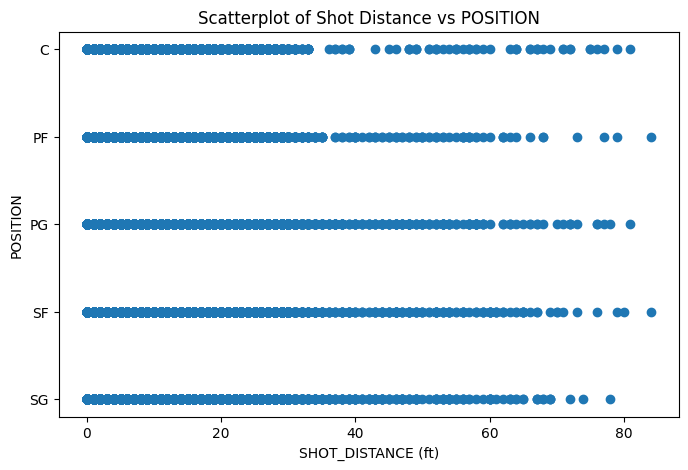

In [29]:
plt.figure(figsize=(8, 5))
plt.scatter(df_clean['SHOT_DISTANCE'], df_clean['POSITION'])
plt.xlabel('SHOT_DISTANCE (ft)')
plt.ylabel('POSITION')
plt.title('Scatterplot of Shot Distance vs POSITION')
plt.show()

In [30]:
remov_outlier = df.shape[0] - df_clean.shape[0]
remov_outlier

8117

In [31]:
df_clean.shape[0]

210584

## 4. Preliminary Analysis

We analyzed the relationship between each explanatory variable and `SHOT_MADE`:

- **Shot Type**: **2-point field goals** have a higher success rate (about **55%**) compared to **3-point field goals** (about **36%**), making **`SHOT_TYPE`** a strong predictor of shot success.
  
- **Court Zone**: **Center (C)** shots have the highest success (about **55%**), while **backcourt (BC)** shots have the lowest (around **3%**). **`ZONE_ABB`** is an important predictor, with shots closer to the basket being more likey to be made.

- **Player Position**: **Centers (C)** have the highest shot success (~**55%**), while **Guards (PG, SG)** and **Forwards (SF, PF)** range from **45%-50%**, meaning **`POSITION`** has moderate predictive power.

- **Shot Distance**: **Made shots** are taken from much **shorter distances** (~**5 feet**), while missed shots are around **18–20 feet**. **`SHOT_DISTANCE`** is a strong predictor of shot success.

- **Quarter**: Shot success doesn't vary much by quarter, making **`QUARTER`** a weak predictor. The gap between made and missed shots narrows in later quarters, possibly due to factors like fatigue, fouls, or timeouts.

### Variable Relationships:

- **Shot Distance and Quarter**: No strong relationship (correlation = **-0.006361**).
  
- **Shot Type and Position**: **Guards (PG, SG, SF)** take more **3-pointers**, while **Centers (C)** focus on **2-point shots**.

### Interaction Effects:

- **Shot Distance and Shot Type**: Longer distances are strongly linked with **3-pointers**, showing an interaction between **`SHOT_TYPE`** and **`SHOT_DISTANCE`**.


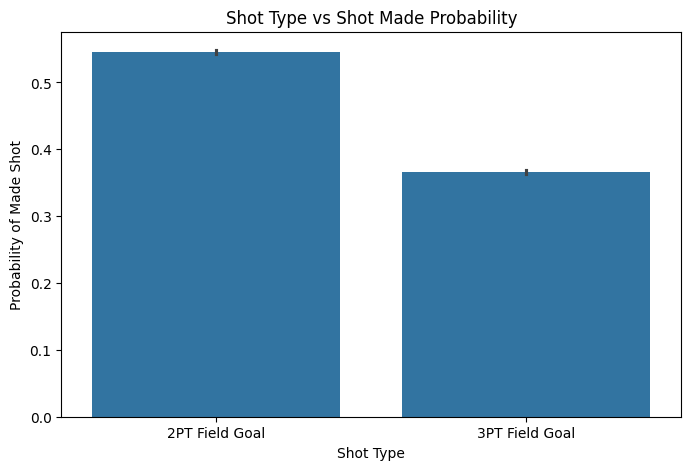

In [32]:
plt.figure(figsize=(8,5))
sns.barplot(data=df_clean, x='SHOT_TYPE', y='y')
plt.title('Shot Type vs Shot Made Probability')
plt.ylabel('Probability of Made Shot')
plt.xlabel('Shot Type')
plt.show()

The probability of making a shot is higher for **2-point field goals** compared to **3-point field goals**, with players making about **55%** of their 2-point shots, while the shot made percentage for 3-point shots drops to around **36%**. This means that `SHOT_TYPE` is a strong predictor of whether a shot will be made, with 2-point shots being more reliable for getting points in basketball.

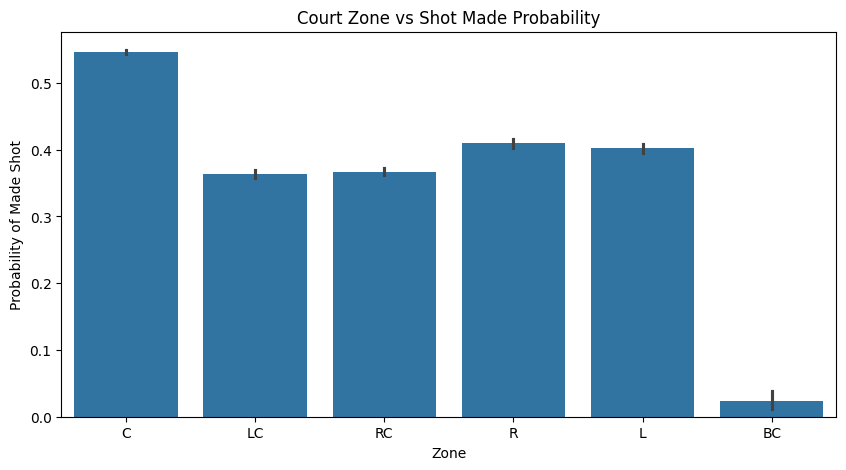

In [33]:
plt.figure(figsize=(10,5))
sns.barplot(data=df_clean, x='ZONE_ABB', y='y')
plt.title('Court Zone vs Shot Made Probability')
plt.ylabel('Probability of Made Shot')
plt.xlabel('Zone')
plt.show()

There is some variation in shot success based on court zone.

- Shots taken from the **center (C)** zone have the highest shot make probability, which is about **55%**.  
- Shots from the **right (R)** and **left (L)** zones follow at roughly **41%** and **40%**, while shots from the **left corner (LC)** and **right corner (RC)** sit near **36–37%**.  
- Shots from the **backcourt (BC)** fall to around **3%**.

This means that **ZONE_ABB** could have strong predictive power, with shots taken closer to the basket generally yielding higher success rates in made shots.


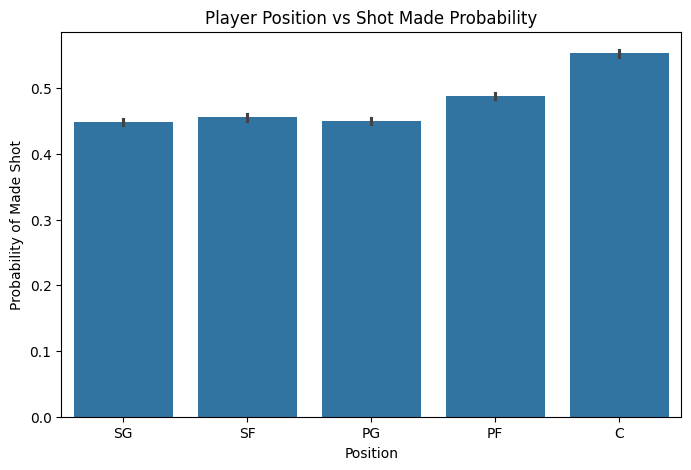

In [34]:
plt.figure(figsize=(8,5))
sns.barplot(data=df_clean, x='POSITION', y='y')
plt.title('Player Position vs Shot Made Probability')
plt.ylabel('Probability of Made Shot')
plt.xlabel('Position')
plt.show()

There is some variation in shot success based on player position.

- **Centers (C)** have the highest shot make probability, which is about 55%.  
- **Power forwards (PF)** follow at roughly 49%.  
- **Small forwards (SF)** sit around 46%.  
- **Guards (PG, SG)** fall near 45%.

This means that **position** could have moderate predictive power, with big men usually taking closer, higher-percentage shots.

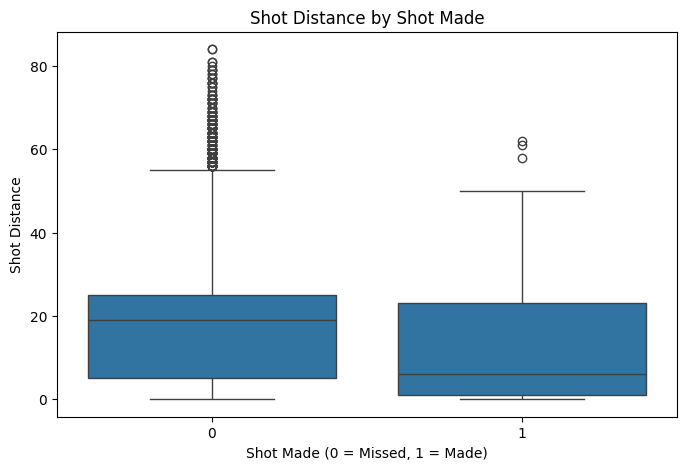

In [35]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_clean, x='y', y='SHOT_DISTANCE')
plt.title('Shot Distance by Shot Made')
plt.xlabel('Shot Made (0 = Missed, 1 = Made)')
plt.ylabel('Shot Distance')
plt.show()

### Shot Distance by Shot Made

Shots that are **made (labeled as 1)** tend to come from much **shorter distances** compared to missed shots. The **median shot distance** for made shots is approximately **5 feet**, while for missed shots, it's around **18–20 feet**. This suggests that **`SHOT_DISTANCE` is a strong numerical predictor** of whether a shot is made, with **shorter shots being more likely to be made.**.


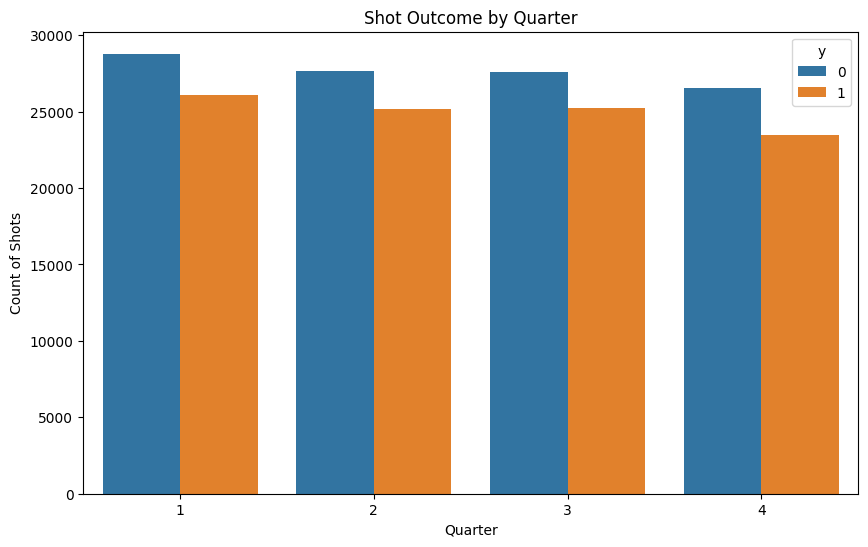

In [36]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_clean, x='QUARTER', hue='y')
plt.title('Shot Outcome by Quarter')
plt.xlabel('Quarter')
plt.ylabel('Count of Shots')
plt.show()

### Shot Outcome by Quarter

The chart shows that **missed shots (0)** consistently outnumber **made shots (1)** across all four quarters. Shot attempts are highest in **Quarter 1** and gradually decrease through **Quarter 4**, suggesting a decline in shooting activity as the game progresses. 

Notably, the gap between made and missed shots narrows in the later quarters, indicating more consistent shooting acuuracy. By **Quarter 4**, the decline in made shots could be attributed to factors like fatigue, defensive pressure, fouls, or timeouts affecting shot opportunities in late-game situations.

In [37]:
corr_matrix = df_clean[['SHOT_DISTANCE', 'QUARTER', 'y']].corr()
corr_matrix

,SHOT_DISTANCE,QUARTER,y
SHOT_DISTANCE,1.000000,-0.006361,-0.229746
QUARTER,-0.006361,1.000000,-0.003661
y,-0.229746,-0.003661,1.000000


**Correlation between Shot Distance and Quarter**: No strong relationship (correlation = **-0.006361**).

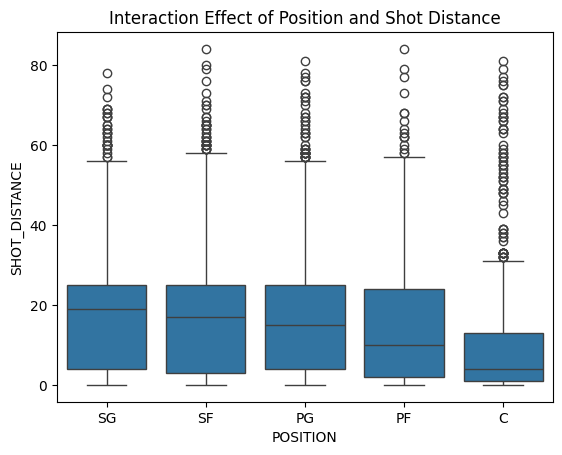

In [38]:
sns.boxplot(data=df_clean, x='POSITION', y='SHOT_DISTANCE')
plt.title('Interaction Effect of Position and Shot Distance')
plt.show()

The box plot shows shot distances based on player position. The **median** shot distances are:

- **SG (Shooting Guard)**: around **19-20 feet**
- **SF (Small Forward)**: around **17-19 feet**
- **PF (Power Forward)**: around **15-17 feet**
- **C (Center)**: under **10-13 feet**

The **quartiles** show how spread out the shot distances are:
- **PFs** and **Centers** have **wider quartiles**, meaning their shot distances can vary more, with some shots taken from farther away.
- **SGs** and **SFs** have **narrower quartiles**, meaning their shots are more consistent, with **SGs** shooting from farther distances.

Overall, **SGs** shoot from farther away, **SFs** from mix ranges, and **PFs** and **Centers** from closer distances with more variety.

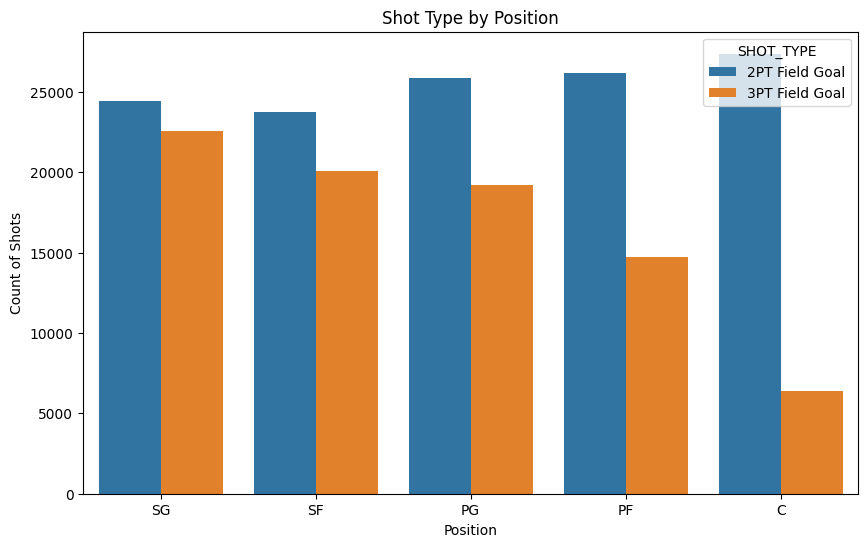

In [39]:
plt.figure(figsize=(10,6))
sns.countplot(data=df_clean, x='POSITION', hue='SHOT_TYPE')
plt.title('Shot Type by Position')
plt.xlabel('Position')
plt.ylabel('Count of Shots')
plt.show()

This graph shows the **count of shots** by **position** and **shot type** (2PT and 3PT).

- **SGs** and **PGs** primarily take **2PT shots**, with **SGs** shooting slightly more overall.
- **SFs** have a more balanced mix of **2PT** and **3PT shots**.
- **PFs** focus on **2PT shots**, with fewer **3PT shots**.
- **Centers (C)** take far more **2PT shots**, with very few **3PT shots**.

Overall, **2PT shots** are more common across all positions, with **Centers** focusing mostly on closer shots (2PT).

## 5. Model Data Preprocessing

In [40]:
vars = df_clean[['SHOT_TYPE', 'ZONE_ABB', 'SHOT_DISTANCE', 'QUARTER', 'POSITION', 'y']]

In [41]:
X = vars.drop(['y'], axis=1)
y = vars['y']

In [42]:
X = pd.get_dummies(X, drop_first=True)

In [43]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
X = pd.DataFrame(scaled_X, columns=X.columns)

In [44]:
print(X.shape)
print(y.shape)
X.head()

(210584, 12)
(210584,)


,SHOT_DISTANCE,QUARTER,SHOT_TYPE_3PT Field Goal,ZONE_ABB_C,ZONE_ABB_L,ZONE_ABB_LC,ZONE_ABB_R,ZONE_ABB_RC,POSITION_PF,POSITION_PG,POSITION_SF,POSITION_SG
0,-0.144287,-1.313229,-0.806448,0.871991,-0.316891,-0.383296,-0.312617,-0.371669,-0.490686,-0.521856,-0.513029,1.865766
1,1.084316,-1.313229,1.240006,0.871991,-0.316891,-0.383296,-0.312617,-0.371669,-0.490686,-0.521856,1.949209,-0.535973
2,-0.994859,-1.313229,-0.806448,0.871991,-0.316891,-0.383296,-0.312617,-0.371669,-0.490686,1.916236,-0.513029,-0.535973
3,-1.183875,-1.313229,-0.806448,0.871991,-0.316891,-0.383296,-0.312617,-0.371669,-0.490686,-0.521856,-0.513029,1.865766
4,-1.183875,-1.313229,-0.806448,0.871991,-0.316891,-0.383296,-0.312617,-0.371669,-0.490686,1.916236,-0.513029,-0.535973


In [45]:
X.corr()
X

,SHOT_DISTANCE,QUARTER,SHOT_TYPE_3PT Field Goal,ZONE_ABB_C,ZONE_ABB_L,ZONE_ABB_LC,ZONE_ABB_R,ZONE_ABB_RC,POSITION_PF,POSITION_PG,POSITION_SF,POSITION_SG
0,-0.144287,-1.313229,-0.806448,0.871991,-0.316891,-0.383296,-0.312617,-0.371669,-0.490686,-0.521856,-0.513029,1.865766
1,1.084316,-1.313229,1.240006,0.871991,-0.316891,-0.383296,-0.312617,-0.371669,-0.490686,-0.521856,1.949209,-0.535973
2,-0.994859,-1.313229,-0.806448,0.871991,-0.316891,-0.383296,-0.312617,-0.371669,-0.490686,1.916236,-0.513029,-0.535973
3,-1.183875,-1.313229,-0.806448,0.871991,-0.316891,-0.383296,-0.312617,-0.371669,-0.490686,-0.521856,-0.513029,1.865766
4,-1.183875,-1.313229,-0.806448,0.871991,-0.316891,-0.383296,-0.312617,-0.371669,-0.490686,1.916236,-0.513029,-0.535973
...,...,...,...,...,...,...,...,...,...,...,...,...
210579,1.273332,1.374884,1.240006,-1.146801,-0.316891,2.608953,-0.312617,-0.371669,-0.490686,-0.521856,-0.513029,1.865766
210580,-0.427811,1.374884,-0.806448,0.871991,-0.316891,-0.383296,-0.312617,-0.371669,-0.490686,-0.521856,-0.513029,-0.535973
210581,-0.900351,1.374884,-0.806448,0.871991,-0.316891,-0.383296,-0.312617,-0.371669,-0.490686,-0.521856,-0.513029,-0.535973
210582,1.462348,1.374884,1.240006,0.871991,-0.316891,-0.383296,-0.312617,-0.371669,-0.490686,-0.521856,-0.513029,1.865766


## 6. Feature Selection with k-Fold Cross-Validation

Elastic Net is best for the matrix because it applies both L1 and L2 penalties, allowing shrinkage and sparsity. LASSO may drop significant but correlated zone dummies, while Ridge keeps all features, even uninformative ones. Elastic Net balances both, retaining key spatial features and removing irrelevant predictors or variables that cause overfitting, leading to the highest test AUC after k-fold cross-validation.

In [46]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression

In [47]:
cv = KFold(n_splits=5, shuffle=True, random_state=207)

results = []

for lam in np.arange(0.001, 0.1, 20):
    C = 1 / lam  
    log_mod = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=C, max_iter=1000)
    auc_scores = cross_val_score(log_mod, X, y, cv=cv, scoring='roc_auc')
    results.append([lam, auc_scores.mean(), auc_scores.std()])

df_auc = pd.DataFrame(results, columns=['lambda', 'mean_auc', 'std_auc'])
df_auc

,lambda,mean_auc,std_auc
0,0.001,0.638252,0.002574


Lambda is very low, close to 0, and a mean AUC of .638 shows minimal regularization. Since elastic uses both penalty terms, it still doesn't do much to reap the benefits of shrinkage. 

## 7. Best Model Discussion

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=207)

In [49]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
X = pd.DataFrame(scaled_X, columns=X.columns)

In [50]:
model = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.5,C=1/0.001,max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1000.0, l1_ratio=0.5, max_iter=1000, penalty='elasticnet',
                   solver='saga')

In [51]:
print(f"Intercept: {model.intercept_[0]}")
for name, coef in zip(X.columns, model.coef_[0]):
    print(f"{name}: {coef}")

Intercept: -0.10774700018524941
SHOT_DISTANCE: -0.7768626884906696
QUARTER: -0.010669389348868848
SHOT_TYPE_3PT Field Goal: 0.30812039872297897
ZONE_ABB_C: 0.5576554448770457
ZONE_ABB_L: 0.3196085454320441
ZONE_ABB_LC: 0.4161808611070065
ZONE_ABB_R: 0.3233725433986023
ZONE_ABB_RC: 0.4025753327001276
POSITION_PF: -0.03083303331238381
POSITION_PG: -0.038327646105368485
POSITION_SF: -0.051600438375622844
POSITION_SG: -0.04338097280269527


In [52]:
X.corr()

,SHOT_DISTANCE,QUARTER,SHOT_TYPE_3PT Field Goal,ZONE_ABB_C,ZONE_ABB_L,ZONE_ABB_LC,ZONE_ABB_R,ZONE_ABB_RC,POSITION_PF,POSITION_PG,POSITION_SF,POSITION_SG
SHOT_DISTANCE,1.000000,-0.006361,0.889940,-0.714938,0.145249,0.412555,0.132630,0.392839,-0.044883,0.078921,0.056242,0.098191
QUARTER,-0.006361,1.000000,0.004010,0.005061,-0.002946,0.003865,-0.004064,-0.003481,0.001204,0.011637,0.005270,0.011209
SHOT_TYPE_3PT Field Goal,0.889940,0.004010,1.000000,-0.627613,0.117779,0.387122,0.095716,0.360198,-0.034042,0.033992,0.067318,0.094458
ZONE_ABB_C,-0.714938,0.005061,-0.627613,1.000000,-0.363410,-0.439564,-0.358509,-0.426231,0.016500,-0.046323,-0.066279,-0.084513
ZONE_ABB_L,0.145249,-0.002946,0.117779,-0.363410,1.000000,-0.121463,-0.099065,-0.117778,0.016134,-0.011549,0.035323,0.025328
ZONE_ABB_LC,0.412555,0.003865,0.387122,-0.439564,-0.121463,1.000000,-0.119825,-0.142459,-0.027613,0.048231,0.012788,0.050346
ZONE_ABB_R,0.132630,-0.004064,0.095716,-0.358509,-0.099065,-0.119825,1.000000,-0.116190,0.012815,-0.004670,0.032258,0.017268
ZONE_ABB_RC,0.392839,-0.003481,0.360198,-0.426231,-0.117778,-0.142459,-0.116190,1.000000,-0.021134,0.034046,0.027447,0.039195
POSITION_PF,-0.044883,0.001204,-0.034042,0.016500,0.016134,-0.027613,0.012815,-0.021134,1.000000,-0.256068,-0.251736,-0.262995
POSITION_PG,0.078921,0.011637,0.033992,-0.046323,-0.011549,0.048231,-0.004670,0.034046,-0.256068,1.000000,-0.267727,-0.279701


The equation for our logistic regression model is:

**`Made Shot`** = **-0.1078** - **0.7768**(`SHOT_DISTANCE`) - **0.0107**(`QUARTER`) + **0.3081**(`SHOT_TYPE_3PT Field Goal`) + **0.5576**(`ZONE_ABB_C`) + **0.3196**(`ZONE_ABB_L`) + **0.4161**(`ZONE_ABB_LC`) + **0.3234**(`ZONE_ABB_R`) + **0.4025**(`ZONE_ABB_RC`) - **0.0308**(`POSITION_PF`) - **0.0383**(`POSITION_PG`) - **0.0516**(`POSITION_SF`) - **0.0434**(`POSITION_SG`)

Our model has an issue with multicollinearity because at least one pair of explanatory variables has a correlation value above our threshold of **0.7**, indicating multicollinearity.

Because of this issue with multicollinearity, we must be cautious in interpreting the slope coefficients. However, since we scaled our explanatory variables, all their standard deviations are roughly the same. Therefore, we can interpret the slope coefficients, but caution is still necessary due to the multicollinearity problem.

In [53]:
def plot_roc(fpr, tpr, auc, lw=2):
    plt.plot(fpr,tpr,color="darkorange",lw=lw,label = "ROC curve (area = "+str(round(auc,3))+")")
    plt.plot([0,1],color = "navy",lw=lw,linestyle = "--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend(loc = "lower right")
    plt.show()

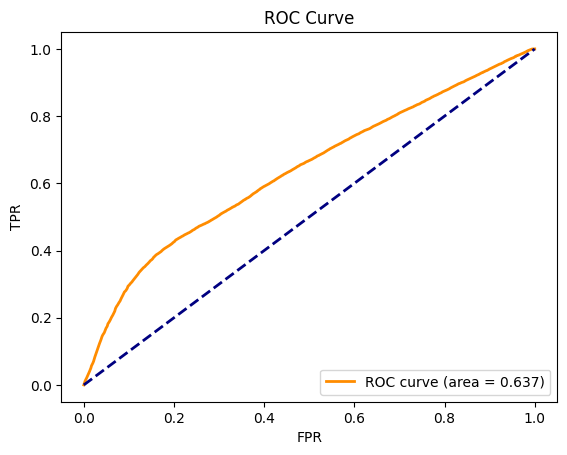

In [54]:
from sklearn.metrics import roc_curve,roc_auc_score
predictive_prob = model.predict_proba(X_test)[:, 1]
fprs, tprs, thresholds = roc_curve(y_true=y_test, y_score=predictive_prob)
auc = roc_auc_score(y_true=y_test, y_score=predictive_prob)
plot_roc(fprs, tprs, auc)

In [55]:
roc_df = pd.DataFrame({"Threshold": thresholds,"TPR": tprs,"FPR": fprs})
roc_df

,Threshold,TPR,FPR
0,inf,0.000000,0.000000
1,0.670515,0.012009,0.002937
2,0.668400,0.021816,0.006597
3,0.666277,0.032174,0.010031
4,0.664148,0.040630,0.012787
...,...,...,...
1843,0.013165,0.999950,0.998690
1844,0.012919,0.999950,0.998780
1845,0.012290,0.999950,0.998825
1846,0.012244,1.000000,0.998825


In [56]:
roc_df.sort_values(by="TPR", ascending=False).head(970)

,Threshold,TPR,FPR
1846,0.012244,1.000000,0.998825
1847,0.002355,1.000000,1.000000
1844,0.012919,0.999950,0.998780
1845,0.012290,0.999950,0.998825
1843,0.013165,0.999950,0.998690
...,...,...,...
882,0.374840,0.801001,0.689725
881,0.374982,0.799600,0.687014
880,0.375019,0.799450,0.686743
879,0.375045,0.797398,0.683806


In [57]:
threshold = 0.374832
y_pred = (predictive_prob >= threshold).astype(int)

In [58]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
print(tpr,fpr)

0.8011508631473605 0.689770468100488


The TPR means that 80.1% of actual shots made were correctly predicted.
The FPR means that 68.7014278% of missed shots were incorrectly predicted as made.

## 8. Additional Analysis/Insight

<Axes: xlabel='SHOT_DISTANCE', ylabel='Predicted_Prob'>

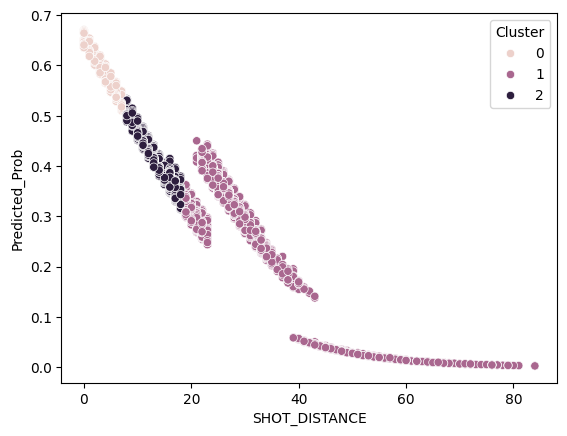

In [59]:
from sklearn.cluster import KMeans
cluster_df = pd.DataFrame({
    'SHOT_DISTANCE': df_clean['SHOT_DISTANCE'],
    'Predicted_Prob': model.predict_proba(X)[:, 1]
})

kmeans = KMeans(n_clusters=3, random_state=207)
cluster_df['Cluster'] = kmeans.fit_predict(cluster_df)

sns.scatterplot(data=cluster_df, x='SHOT_DISTANCE', y='Predicted_Prob', hue='Cluster')

We applied KMeans clustering to determine if shots could be segmented according to SHOT_DISTANCE and scoring probability from our logistic regression output. As depicted in the plot, three clusters were formed: one for close shots with high predicted probabilities of scoring, one for shots taken at the midpoint with nominally predicted scoring averages, and one for long-distance tries (three-pointers) with low probabilities of scoring. This finding adds to our goal of actionable recommendations because it indicates to coaches/analysts which shots are more effective in scoring. Thus, more focus should be given to shots taken up close and less trust in shots taken far away with projected failures.

## 9. Conclusion

The average test AUC, our final elastic net logistic regression model emerged as the top performer, achieving an AUC of approximately 0.638. While this value doesn’t suggest perfect prediction, it does indicate moderate predictive power and offers useful insights into how shot characteristics influence success. Given this, I would recommend the use of our model for a coach or data analyst looking to improve team shooting strategies or player development. It can help highlight trends, such as when certain shot types or court regions are less effective, and aid in smarter decision making on the court. We can't say with certainty that this is the best possible model that could be built using this dataset. There’s still room to explore techniques to boost accuracy. Additionally, our model does not include many potentially predictive features, such as defender distance, shot clock timing, or player fatigue, factors that could heavily influence shot success. For future work, it would be interesting to train models specific to each player or position group. This could better account for individual shooting tendencies and possibly lead to more personalized training or game planning recommendations. Overall, our project builds a solid foundation, but it also opens the door to further analysis.